This script was made based on Tensorflow's tutorial: https://www.tensorflow.org/tutorials/load_data/images

In [23]:
# imports

from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.enable_eager_execution()  # enables imperative execution without building tensor graphs (debug mode)

AUTOTUNE = tf.data.experimental.AUTOTUNE  # an alias to write less
EPOCHS = 100
IMG_W = 96
IMG_H = 96
TRAIN_TEST_RATIO = 0.8

EPOCHS  # só pra verificar que a execução terminou

100

In [24]:
# scan image paths

data_root = pathlib.Path('quadros')
all_image_paths = list(data_root.glob('*/*.jpg'))

# só pra verificar que a execução terminou
for item in data_root.iterdir():
  print(item)

quadros/pop
quadros/maneirismo
quadros/impressionismo
quadros/romantismo


In [25]:
# count and shuffle

all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)

image_count  # só pra verificar que a execução terminou

160

In [26]:
# create file->label association

# labels are folders
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index,name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

# só pra verificar que a execução terminou
print(label_names)
print("First 10 labels indices: ", all_image_labels[:10])

['impressionismo', 'maneirismo', 'pop', 'romantismo']
First 10 labels indices:  [0, 0, 1, 0, 2, 1, 2, 3, 3, 0]


In [27]:
# preprocessing and helper methods

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)  #  carrega as imagens pra memória
  image = tf.image.resize(image, [IMG_W, IMG_H])  #  redimensiona elas
  image = tf.image.rgb_to_grayscale(image)  #  trás pra escala de cinza [W x H x 3] -> [W x H]
  image = tf.reshape(image, (9216,))  #  transforma em um vetor
  image /= 255.0 # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

# só pra verificar que a execução terminou
load_and_preprocess_image

<function __main__.load_and_preprocess_image(path)>

In [28]:
# creating tensorflow dataset

path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
# run preprocessing methods
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
# zip images to it's labels (as they have the same order)
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

# só pra verificar que a execução terminou
image_label_ds

<DatasetV1Adapter shapes: ((9216,), ()), types: (tf.float32, tf.int64)>

In [30]:
# prepare the dataset to begin training

BATCH_SIZE = int(image_count * TRAIN_TEST_RATIO)  # so we can train the entire dataset on every epoch

test_dataset = image_label_ds.skip(image_count - BATCH_SIZE) 
train_dataset = image_label_ds.take(BATCH_SIZE)

# setting a shuffle buffer size as large as the dataset ensures that the data is completely shuffled
ds = train_dataset.shuffle(buffer_size=BATCH_SIZE)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training
ds = ds.prefetch(buffer_size=AUTOTUNE)

# setup test dataset
tds = train_dataset.shuffle(buffer_size=image_count-BATCH_SIZE)
tds = tds.repeat()
tds = tds.batch(image_count - BATCH_SIZE)
tds = tds.prefetch(buffer_size=AUTOTUNE)

# só pra verificar que a execução terminou
BATCH_SIZE

128

In [33]:
# define the model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(4608, input_dim=9216, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

# só pra verificar que a execução terminou
model

In [36]:
model.compile(
    optimizer = 'rmsprop', 
    #tf.train.AdamOptimizer
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics = ["accuracy"]
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4608)              42471936  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 18436     
Total params: 42,490,372
Trainable params: 42,490,372
Non-trainable params: 0
_________________________________________________________________


In [37]:
# train the model
H = model.fit(
    ds,  # the dataset
    epochs=EPOCHS,  # number of times to loop on this dataset
    steps_per_epoch=int(len(all_image_paths)/BATCH_SIZE),  # how many samples to take from this ds
)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.5040 - acc: 0.3047
Epoch 2/100
1/1 [==============================] - 0s 91ms/step - loss: 11.9400 - acc: 0.2578
Epoch 3/100
1/1 [==============================] - 0s 91ms/step - loss: 12.5923 - acc: 0.2188
Epoch 4/100
1/1 [==============================] - 0s 87ms/step - loss: 12.5923 - acc: 0.2188
Epoch 5/100
1/1 [==============================] - 0s 84ms/step - loss: 12.5923 - acc: 0.2188
Epoch 6/100
1/1 [==============================] - 0s 85ms/step - loss: 12.5923 - acc: 0.2188
Epoch 7/100
1/1 [==============================] - 0s 82ms/step - loss: 12.5923 - acc: 0.2188
Epoch 8/100
1/1 [==============================] - 0s 82ms/step - loss: 12.5923 - acc: 0.2188
Epoch 9/100
1/1 [==============================] - 0s 85ms/step - loss: 12.5923 - acc: 0.2188
Epoch 10/100
1/1 [==============================] - 0s 84ms/step - loss: 12.5923 - acc: 0.2188
Epoch 11/100
1/1 [==============================] - 0s 85ms/st

Epoch 88/100
1/1 [==============================] - 0s 84ms/step - loss: 12.5923 - acc: 0.2188
Epoch 89/100
1/1 [==============================] - 0s 83ms/step - loss: 12.5923 - acc: 0.2188
Epoch 90/100
1/1 [==============================] - 0s 88ms/step - loss: 12.5923 - acc: 0.2188
Epoch 91/100
1/1 [==============================] - 0s 89ms/step - loss: 12.5923 - acc: 0.2188
Epoch 92/100
1/1 [==============================] - 0s 82ms/step - loss: 12.5923 - acc: 0.2188
Epoch 93/100
1/1 [==============================] - 0s 81ms/step - loss: 12.5923 - acc: 0.2188
Epoch 94/100
1/1 [==============================] - 0s 83ms/step - loss: 12.5923 - acc: 0.2188
Epoch 95/100
1/1 [==============================] - 0s 89ms/step - loss: 12.5923 - acc: 0.2188
Epoch 96/100
1/1 [==============================] - 0s 83ms/step - loss: 12.5923 - acc: 0.2188
Epoch 97/100
1/1 [==============================] - 0s 84ms/step - loss: 12.5923 - acc: 0.2188
Epoch 98/100
1/1 [==============================] 

In [38]:
score = model.evaluate(tds, verbose=1, steps=int(image_count - BATCH_SIZE))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

32/32 [==============================] - 0s 11ms/step - loss: 12.5923 - acc: 0.2188
Test loss: 12.592262119054794
Test accuracy: 0.21875


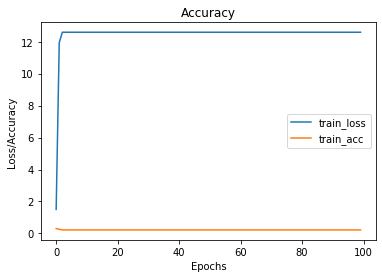

In [39]:
# plot statistics

plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["acc"], label="train_acc")
# plt.plot(np.arange(0, EPOCHS), H.history["val_acc"], label="val_acc")
# plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()